In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPool1D, LSTM, Dropout, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
from datetime import datetime

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.0.0


In [3]:
tscv = TimeSeriesSplit(n_splits=5)
seed = 7
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

folder = os.path.join(os.getcwd(), datetime.now().strftime("%d-%m-%Y_%H-%M-%S"))
history_file = folder + "\rnn_" + ".h5"
save_callback = ModelCheckpoint(filepath=history_file, verbose=1)
tb_callback = TensorBoard(log_dir=folder)

In [4]:
def result_to_numeric(x):
    if x=='W' or x=='w':
        return 1
    elif x=='L' or x=='l':
        return 0

In [5]:
# Read data
df = pd.read_csv('completeFinalDatasetFrom79_Pruned.csv', sep=',')
df = df.drop(['Year','TeamA','TeamB'],axis=1)
df['WL'] = df['WL'].apply(result_to_numeric)
print(df.head())

   O_ORebDiff  O_DRebDiff  O_AsstDiff  O_PFDiff  O_STLDiff  O_TODiff  \
0   -0.852744    0.220118    0.725228 -1.624636   0.502332  1.219331   
1    0.624856    1.077818    0.657237 -0.524262   0.468844 -0.359382   
2    1.771649   -2.261899   -0.802283 -1.013957   0.122792 -0.154021   
3   -1.080633   -0.667943    0.113317 -0.190117   2.924691  2.104951   
4    0.102917    1.480102    0.589247 -0.397517  -1.495834  0.064175   

   O_BlkDiff  O_x3PMDiff  O_FGPDiff  O_FTPDiff  D_ORebDiff  D_DRebDiff  \
0  -0.141657    0.239121   0.635920   1.072682    0.663973   -1.368963   
1  -0.519410    0.183512  -0.240265   0.886943    0.567872    0.354402   
2   0.472191    0.289170  -0.764677  -1.223977    0.366933   -1.077103   
3   2.467195   -0.255804   1.423435   0.492501    1.057116   -2.223696   
4   2.384562   -0.266926   1.496380   0.085936    0.838703   -1.424555   

   D_AsstDiff  D_PFDiff  D_BlkDiff  D_x3PMDiff  D_FTPDiff  WL  
0    1.177983 -0.134638  -0.576137    0.362318  -0.717179 

In [6]:
X_train_complete, X_test_complete, y_train_complete, y_test_complete = train_test_split(
    df.values[:,:-1],
    df.values[:,-1],
    test_size=0.30,
    random_state=7,
    shuffle=False)

In [7]:
X_train_complete, X_val_complete, y_train_complete, y_val_complete = train_test_split(
    X_train_complete,
    y_train_complete,
    test_size=0.1,
    random_state=7,
    shuffle=False)

In [8]:
X_train_complete = np.reshape(X_train_complete,(X_train_complete.shape[0],1,X_train_complete.shape[1]))
X_test_complete = np.reshape(X_test_complete,(X_test_complete.shape[0],1,X_test_complete.shape[1]))
X_val_complete = np.reshape(X_val_complete,(X_val_complete.shape[0],1,X_val_complete.shape[1]))

In [9]:
y_train_complete = np.reshape(y_train_complete,(y_train_complete.shape[0],1))
y_test_complete = np.reshape(y_test_complete,(y_test_complete.shape[0],1))
y_val_complete = np.reshape(y_val_complete,(y_val_complete.shape[0],1))

In [10]:
def build_model(lstm_neurons,activation_1,activation_2,learning_rate,dropout):
    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_neurons, return_sequences=True)))
    model.add(Dense(32,activation=activation_1))
    model.add(Dropout(dropout))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16,activation=activation_2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate),metrics=['acc'])
    return model

In [11]:
def train_model(model, x_train, y_train, x_val, y_val, BATCH_SIZE, NUM_EPOCHS):
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        shuffle=True,
        validation_data=(x_val, y_val),
        #callbacks=[save_callback, tb_callback],
        verbose=2
    )
    history_dict = history.history
    train_accuracy = history_dict["acc"]
    train_loss = history_dict["loss"]
    valid_accuracy = history_dict["val_acc"]
    valid_loss = history_dict["val_loss"]
    return train_accuracy, train_loss, valid_accuracy, valid_loss

In [12]:
def test_model(model, x_test, y_test):
    # predictions with test set
    predictions = model.predict(
        x=x_test,
        batch_size=None,
        verbose=0
    )
    predictions = np.round(predictions)
    predictions = predictions.astype(int)
    test_accuracy = acc(y_test,predictions)
    return test_accuracy,predictions

In [ ]:
model =  KerasClassifier(build_fn=build_model,lstm_neurons=9,activation_1='relu',activation_2='relu',learning_rate=0.001,dropout=0.5,verbose=2)

In [ ]:
train_accuracy, train_loss, valid_accuracy, valid_loss = train_model(model,
                                    X_train_complete,y_train_complete,
                                    X_val_complete,y_val_complete,
                                    3,11,save_callback,tb_callback)

In [ ]:
test_accuracy, predictions = test_model(model, X_test_complete, y_test_complete)
# save test set results and print accuracy
print(test_accuracy)

In [ ]:
################################################################################
# Visualization and Output
num_epochs_plot = range(1, len(train_accuracy) + 1)

# Loss curves
plt.figure(1)
plt.plot(num_epochs_plot, train_loss, "b", label="Training Loss")
plt.plot(num_epochs_plot, valid_loss, "r", label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Plots/rnnLoss.png')
plt.show()

In [ ]:
plt.figure(2)
plt.plot(num_epochs_plot, train_accuracy, "b", label="Training Accuracy")
plt.plot(num_epochs_plot, valid_accuracy, "r", label="Validation Accuracy")
plt.title("Accuracy Curves_")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Plots/rnnAcc.png')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score as acc, roc_curve,auc
fpr, tpr, threshold = roc_curve(y_test_complete, predictions)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('Plots/rnnAUC.png')
plt.show()

In [15]:
import time
param_val = [0.001,0.003,0.005]
parm = 'Learning Rate'
val_train_loss = np.zeros(len(param_val))
val_train_acc = np.zeros(len(param_val))
val_valid_acc = np.zeros(len(param_val))
val_valid_loss = np.zeros(len(param_val))
train_time = np.zeros(len(param_val))

# Build and train the model and record validation and loss statistics for each value of the hyperparameter
# Make sure to add the [val] index after the hyper parameter that will be tuned.
for val, param in enumerate(param_val):
    model =  KerasClassifier(build_fn=build_model,lstm_neurons=9,activation_1='relu',
                             activation_2='relu',learning_rate=param_val[val],dropout=0.5,verbose=1)
    t0 = time.time()
    train_accuracy, train_loss, valid_accuracy, valid_loss = train_model(model,
                                    X_train_complete,y_train_complete,
                                    X_val_complete,y_val_complete,
                                    4,10)
    t1 = time.time()
    train_time[val] = t1-t0
    val_train_loss[val] = train_loss[-1]
    val_train_acc[val] = train_accuracy[-1]
    val_valid_loss[val] = valid_loss[-1]
    val_valid_acc[val] = valid_accuracy[-1]

Train on 234 samples, validate on 27 samples
Epoch 1/10
234/234 - 4s - loss: 0.6719 - acc: 0.6197 - val_loss: 0.6086 - val_acc: 0.8148
Epoch 2/10
234/234 - 0s - loss: 0.6208 - acc: 0.7009 - val_loss: 0.5363 - val_acc: 0.8148
Epoch 3/10
234/234 - 0s - loss: 0.5793 - acc: 0.7051 - val_loss: 0.4972 - val_acc: 0.8148
Epoch 4/10
234/234 - 0s - loss: 0.5602 - acc: 0.7009 - val_loss: 0.4694 - val_acc: 0.8148
Epoch 5/10
234/234 - 0s - loss: 0.5515 - acc: 0.7009 - val_loss: 0.4544 - val_acc: 0.8148
Epoch 6/10
234/234 - 0s - loss: 0.5346 - acc: 0.7051 - val_loss: 0.4436 - val_acc: 0.8148
Epoch 7/10
234/234 - 0s - loss: 0.5223 - acc: 0.6966 - val_loss: 0.4334 - val_acc: 0.8148
Epoch 8/10
234/234 - 0s - loss: 0.4983 - acc: 0.7393 - val_loss: 0.4148 - val_acc: 0.8148
Epoch 9/10
234/234 - 0s - loss: 0.4931 - acc: 0.7393 - val_loss: 0.4248 - val_acc: 0.8519
Epoch 10/10
234/234 - 0s - loss: 0.4749 - acc: 0.7821 - val_loss: 0.4077 - val_acc: 0.8148
Train on 234 samples, validate on 27 samples
Epoch 1/1

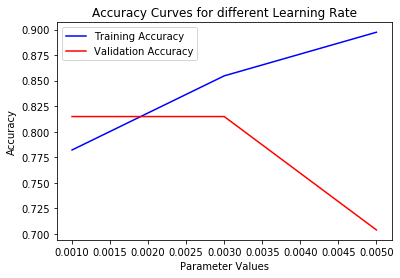

In [16]:

# Visualization and Output
plt.figure(2)
plt.plot(param_val, val_train_acc, "b", label="Training Accuracy")
plt.plot(param_val, val_valid_acc, "r", label="Validation Accuracy")
plt.title("Accuracy Curves for different " + parm)
plt.xlabel("Parameter Values")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Plots/' + parm + '_acc.png')
#plt.show()